# Predict the next seen movies

> The goal of this project is to validate your skills learned during the previous tutorials with the PySpark distributed computing software. You will build and test several implementations of recommendation systems. Here are the parts of the project:
>
> * Part A: Load and preprocess the dataset.
> * Part B: Build a first set of recommendation algorithms: naive with recurring pairs, a priori, and fp-growth to infer rules from a dataset.
> * Part C: Implement the PLSI algorithm ("Probabilistic Latent Semantic Indexing"), which is one way to create embeddings from a dataset. These embeddings can be used to fuel a recommendation engine.
> * Part D: Predict the next movies seen by a user in function of the last movies that he/she has seen with the previous implemented algorithms.

# Setup

## Install Spark Environment

> Since you are running on Google Colab, you will need to install Spark by ourselves, every time we run a new session. You need to install Spark, as well as a Java Runtime Environment.  Then you need to setup a few environment variables.

Execute:

or directly with:

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c230da6d9d62258b9d1c7973ae94e815f22d5d2eec384ff4565a269c38dd4865
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Create and launch a Spark session with:

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')

spark = SparkSession.builder.config(conf=conf)\
  .master('local[*]')\
  .getOrCreate()

sc = spark.sparkContext

In [3]:
spark

/!\ The Spark UI link is not accessible. Use the optional next session if you want to access it.

Uncomment and execute the following line, if you want to close and stop the created Spark session

In [4]:
# spark.stop()

## Optional step: Enable Spark UI access through a secure tunnel

> This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.

In [5]:
# !uname -a

In [6]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [7]:
# !./ngrok authtoken '2HYfdysedjgB5lcoeE8lqqShgIe_sZUm49MquX5okpssVMYQ' # <-------------- change this line !

In [8]:
# get_ipython().system_raw('./ngrok http 4050 &')

In [9]:
# import json
# import urllib

# ngrok_tunnels = urllib.request.urlopen('http://localhost:4040/api/tunnels').read().decode('utf8')
# spark_ui_url = json.loads(ngrok_tunnels)['tunnels'][0]['public_url']
# print("Spark UI:", spark_ui_url)

## Other Imports

In [10]:
import sys
import urllib.request as req
import zipfile
import glob
from datetime import datetime
from fractions import Fraction
from decimal import Decimal

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark import StorageLevel
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType, BooleanType, Tuple, FloatType
from pyspark.sql.window import Window

#Additional imports
import gc
from itertools import combinations

# Part A - Dataset (5 points)

## Loading the dataset

In [11]:
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
filehandle, _ = req.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist()
zip_file_object.extractall()

In [12]:
!find ml-20m -type f

ml-20m/tags.csv
ml-20m/README.txt
ml-20m/genome-scores.csv
ml-20m/ratings.csv
ml-20m/movies.csv
ml-20m/links.csv
ml-20m/genome-tags.csv


In [13]:
movies_path = "ml-20m/movies.csv"
ratings_path = "ml-20m/ratings.csv"

In [14]:
ratings_df_csv = spark.read.options(header=True, inferSchema=True).csv(ratings_path)
movies_df_csv = spark.read.options(header=True, inferSchema=True).csv(movies_path)

In [15]:
ratings_df_csv

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

## Preprocessing

> In the following sections, we will work with algorithms that may scale more or less well with the size of the dataset. In this section we will develop several functions that will allow you to sample the dataset. Then in the next part of the notebook, it will be up to you to choose which tools you want to apply to your dataset in order to train your models, knowing that we want to have reasonable processing times (in the order of a minute), while having models that 'work' well.
>
> **Test all the functions that process the dataframe on a toy example, like what is done in first data processing question.**

### Question A1

>Write the *ratings_df_csv* and *movies_df_csv* DataFrame in a compressed parquet format.
>
>Reload them from parquet, to make next computations faster.

In [16]:
ratings_parquet_path = 'ml-20m/ratings.parquet'
ratings_df_csv.write.mode("overwrite").parquet(ratings_parquet_path)

In [17]:
movies_parquet_path = 'ml-20m/movies.parquet'
movies_df_csv.write.mode("overwrite").parquet(movies_parquet_path)

In [18]:
ratings_df_parquet = spark.read.parquet(ratings_parquet_path)

In [19]:
movies_df_parquet = spark.read.parquet(movies_parquet_path)

In [20]:
movies_df_parquet

DataFrame[movieId: int, title: string, genres: string]

### Question A2

> Compute an estimation of the whole *ratings_df* dataset size in memory.
>
>Find the amount of partitions used by *ratings_df*.
>
>We try to have partitions not too big (in order not to crash our executors), and not to small (dealing with too many small partitions can lead to issues, on driver side for example). For this reason, a rule of thumb to have partitions of 128MB is okay. Given this, what do you think of the dataframe? Is the amount of partitions okay? Or should we repartition it? What would be the function to use if we need to repartition the dataframe?

In [21]:
ratings_df_parquet.printSchema()
ratings_df_parquet.count()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



20000263

**ANSWER**
* 'userId' is an integer column, each integer is stored in 32 bits (=4 Bytes)
* The same goes for 'movieId' and 'timestamp'. 'rating' is a double stored in 64 bits (=8 Bytes)
* So each rows contains (3*4)+8 = 20 Bytes of data, for a total of 20 000 263 * 20 Bytes <br>  
That is a total of 400 005 260 Bytes (~ 400 MB)

In [22]:
ratings_df_csv.rdd.getNumPartitions()

4

In [23]:
ratings_df_parquet.rdd.getNumPartitions()

2

* The dataframe is split into 2 partitions in parquet format and 4 in csv format
* This does not respect the rule of thumb of having roughly 128 MB per partition
* To respect to the rule of thumb, we should split the dataset into 3 partitions using df.repartition(3)

In [24]:
ratings_df_parquet = ratings_df_parquet.repartition(3)

In [25]:
ratings_df_parquet.rdd.getNumPartitions()

3

### Question A3

>Create a function named *remove_bad_ratings* that takes a rating dataframe as an argument, and returns a dataframe whose ratings are greater or equals to a rating_threshold, with default value of *3.5*.

In [26]:
def remove_bad_ratings(rating_df,
                       threshold=3.5):
  return rating_df.filter(rating_df.rating>=threshold)

In [27]:
good_ratings_df = remove_bad_ratings(ratings_df_parquet)

In [28]:
good_ratings_df.take(5)

[Row(userId=42913, movieId=930, rating=4.0, timestamp=985661582),
 Row(userId=1131, movieId=1210, rating=4.0, timestamp=862594943),
 Row(userId=55563, movieId=337, rating=4.0, timestamp=1346832403),
 Row(userId=32274, movieId=3148, rating=4.5, timestamp=1143254050),
 Row(userId=19697, movieId=1089, rating=5.0, timestamp=1120575477)]

### Question A4

>Create a function named *sample_users* that takes a rating dataframe as an argument, and returns a dataframe with only a *ratio* of users (we want to keep all ratings from users that we keep) ; default value of *ratio* parameter is *0.1*. Function should be deterministic.

In [29]:
def sample_users(rating_df, ratio=0.1):
  return rating_df.filter(F.hash('userId') % int(1/ratio) == 0)

In [30]:
ratings_small_df = sample_users(ratings_df_parquet, ratio = 0.10)

Testing if the small df has more or less 10% the original dataframe size i.e. 2M rows. <br>

In [31]:
ratings_small_df.count()

1973662

In [32]:
ratings_small_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
| 51793|   2528|   5.0| 992150670|
| 60271|   2089|   4.0|1129599380|
| 47045|      1|   5.0| 982395391|
| 13376|   2268|   4.0| 973220222|
| 62599|   3255|   3.0|1108532462|
+------+-------+------+----------+
only showing top 5 rows



### Question A5

> Create a function named *remove_exotic_movies*, taking a rating dataframe as argument, and that removes all movies which have less than *nb_min_ratings* ; *nb_min_ratings* parameter has a default value of *1000*.

In [33]:
def remove_exotic_movies(rating_df,
                         nb_min_ratings=1000,
                         drop_count=False):
    #We don't want to modify in the input df so we will do the transformations in an other variable
    nb_ratings_per_movie = rating_df.groupBy('movieId').agg(F.count('rating').alias('count'))
    result = rating_df.join(nb_ratings_per_movie, on='movieId', how='left')
    result = result.filter(f"count >= {nb_min_ratings}")
    #Wether we want to keep the column counting the amount of ratings
    if drop_count :
      result = result.drop("count")
    return result

In [34]:
remove_exotic_movies(ratings_small_df, drop_count=False).head(5)

[Row(movieId=1580, userId=54456, rating=5.0, timestamp=974792198, count=3510),
 Row(movieId=1580, userId=20351, rating=4.0, timestamp=1115685444, count=3510),
 Row(movieId=1580, userId=50611, rating=5.0, timestamp=958264661, count=3510),
 Row(movieId=1580, userId=52935, rating=3.0, timestamp=1131579026, count=3510),
 Row(movieId=1580, userId=70394, rating=2.0, timestamp=1057994061, count=3510)]

### Question A6

> Compute the following stats on the dataset:
> - Amount of distinct users
> - Amount of distinct movies
> - Total amount of ratings
> - Let r_u be the amount of ratings made by user u. Study the distribution of r_u over all users (quantiles, histogram...)

In [35]:
def df_stats(rating_df) :
  nb_distinct_users = rating_df.select('userId').distinct().count()
  print(f"Amount of distinct users : {nb_distinct_users}")
  nb_distinct_movies = rating_df.select('movieId').distinct().count()
  print(f"Amount of distinct movies : {nb_distinct_movies}")
  nb_ratings = rating_df.count()
  print(f"Total amount of ratings : {nb_ratings}")

In [36]:
df_stats(ratings_df_parquet)

Amount of distinct users : 138493
Amount of distinct movies : 26744
Total amount of ratings : 20000263


In [37]:
def r_u_stats(rating_df, show_hist=False):
    ratings_per_user = rating_df.groupBy('userId').agg(F.count('rating').alias('r_u'))
    ratings_per_user.select('r_u').summary("count", "mean", "min", "25%", "50%", "75%", "max").show()
    if show_hist :
        ratings_per_user_values = [row.r_u for row in ratings_per_user.select('r_u').collect()]
        plt.hist(ratings_per_user_values, bins=50, log=True);

+-------+------------------+
|summary|               r_u|
+-------+------------------+
|  count|             13870|
|   mean|142.29718817591925|
|    min|                20|
|    25%|                34|
|    50%|                66|
|    75%|               152|
|    max|              5356|
+-------+------------------+



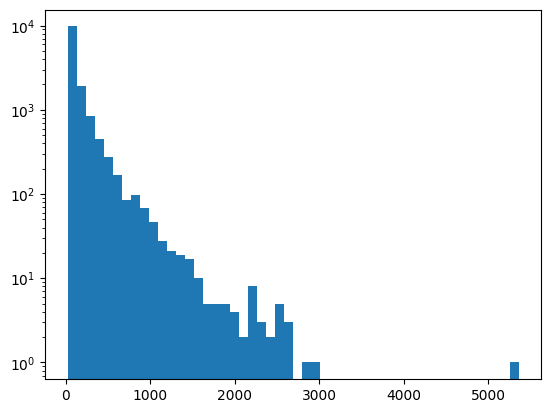

In [38]:
r_u_stats(ratings_small_df, True)

In [39]:
gc.collect()

14807

### Question A7

> Create a function named *remove_old_movies_in_timelines*, that takes a ratings dataframe as parameter, and only keeps the *nb_max_movies* most recent movies seen by each user ; *nb_max_movies* parameter is defaulted at 100.

In [40]:
def remove_old_movies_in_timelines(rating_df,
                                   nb_max_movies=100):
  # Define a window specification partitioned by 'userId' and ordered by 'timestamp' in descending order
  window_spec = Window.partitionBy("userId").orderBy(F.col("timestamp").desc())
  # Add a new column 'most_recent' representing the rank of each row within its partition
  df_with_rank = rating_df.withColumn("most_recent", F.row_number().over(window_spec))
  # Filter out rows where 'rank' is less than or equal to 100
  result_df = df_with_rank.filter(F.col("most_recent") <= nb_max_movies)
  return result_df

In [41]:
remove_old_movies_in_timelines(ratings_small_df.filter("userId == 60271")).tail(20)

[Row(userId=60271, movieId=8873, rating=4.0, timestamp=1131858185, most_recent=81),
 Row(userId=60271, movieId=1449, rating=4.0, timestamp=1131858085, most_recent=82),
 Row(userId=60271, movieId=30812, rating=2.0, timestamp=1131857834, most_recent=83),
 Row(userId=60271, movieId=2302, rating=3.0, timestamp=1131483756, most_recent=84),
 Row(userId=60271, movieId=303, rating=1.5, timestamp=1131483714, most_recent=85),
 Row(userId=60271, movieId=1127, rating=3.5, timestamp=1131483690, most_recent=86),
 Row(userId=60271, movieId=5669, rating=5.0, timestamp=1130128857, most_recent=87),
 Row(userId=60271, movieId=4979, rating=3.5, timestamp=1130128770, most_recent=88),
 Row(userId=60271, movieId=2395, rating=4.0, timestamp=1130128763, most_recent=89),
 Row(userId=60271, movieId=30810, rating=4.5, timestamp=1130128745, most_recent=90),
 Row(userId=60271, movieId=4878, rating=4.0, timestamp=1130128382, most_recent=91),
 Row(userId=60271, movieId=765, rating=2.5, timestamp=1130128050, most_rece

# Part B - Association Rules (5 points)

## Naive: Recurring pairs

> This approach is simple and not efficient but gives you a baseline and intuition for the next steps.
>
> Morally, what we want to do is:
> - for each user, regroup all the movies they have liked inside a single row. We will call this the 'user timeline'
> - for each user, generate all pairs of movies across their list of movies.
> - for each pair of movies, count the amount of distinct users with this pair.



Before starting part B, we will create a very small subset of ratings_df to test our functions

In [42]:
ratings_small_df = sample_users(ratings_df_parquet, ratio = 0.01) #20M rows -> 200k rows
ratings_small_df = remove_bad_ratings(ratings_small_df, threshold = 3.5)
ratings_small_df = remove_exotic_movies(ratings_small_df, nb_min_ratings=100, drop_count=True)

In [43]:
ratings_small_df.cache()

DataFrame[movieId: int, userId: int, rating: double, timestamp: int]

In [44]:
ratings_small_df.head(5)

[Row(movieId=1580, userId=116159, rating=5.0, timestamp=901306654),
 Row(movieId=1580, userId=137912, rating=4.5, timestamp=1112382039),
 Row(movieId=1580, userId=82224, rating=3.5, timestamp=1111473046),
 Row(movieId=1580, userId=74757, rating=3.5, timestamp=1064772181),
 Row(movieId=1580, userId=122834, rating=4.0, timestamp=878135856)]

In [45]:
ratings_small_df.count()

44513

### Question B1

> Create a function named *compute_timeline*, that takes a ratings dataframe as parameter, and returns the 'user timeline', a dataframe following this schema:
> - userId : integer
> - movies : list[integer] (list of movieId seen by user)
>
> Test it on a toy example.

In [46]:
def compute_timeline(rating_df):
  user_timeline = rating_df.groupby('userId').agg(F.collect_list("movieId").alias('movies'))
  return user_timeline

In [47]:
compute_timeline(ratings_small_df).tail(1)

[Row(userId=138390, movies=[1265, 2396, 2797, 497, 300, 1307, 1148, 2502, 1961, 1207, 912, 1247, 1394, 920, 1968, 919, 2571, 1225, 904, 903, 1641, 594, 2324, 39, 21, 1393, 457, 953, 1617, 1196, 541, 260, 1954, 357, 2599])]

In [48]:
ratings_small_df.filter("userId == 138390").show()

+-------+------+------+---------+
|movieId|userId|rating|timestamp|
+-------+------+------+---------+
|   1265|138390|   4.0|945188228|
|   2396|138390|   5.0|945188161|
|   2797|138390|   5.0|945189468|
|    497|138390|   5.0|945189057|
|    300|138390|   4.0|945188751|
|   1307|138390|   5.0|945188823|
|   1148|138390|   4.0|945190519|
|   2502|138390|   4.0|945189407|
|   1961|138390|   4.0|945189487|
|   1207|138390|   5.0|945188047|
|    912|138390|   4.0|945190457|
|   1247|138390|   4.0|945187161|
|   1394|138390|   4.0|945188287|
|    920|138390|   5.0|945190761|
|   1968|138390|   4.0|945189507|
|    919|138390|   5.0|945187819|
|   2571|138390|   4.0|945188228|
|   1225|138390|   4.0|945190669|
|    904|138390|   5.0|945187844|
|    903|138390|   5.0|945187939|
+-------+------+------+---------+
only showing top 20 rows



### Question B2

> Let's imagine that all of our executors have 4GB of memory. If we consider the 'user timeline' dataset where movie ratings are greater or equal than 3.5, is it okay to store list of movie ids inside rows, as far as memory is concerned?

In [49]:
good_ratings_df = remove_bad_ratings(ratings_df_parquet, threshold=3.5)

In [50]:
df_stats(good_ratings_df)

Amount of distinct users : 138362
Amount of distinct movies : 22884
Total amount of ratings : 12195566


In [51]:
good_ratings_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

If we only keep the good ratings (>=3.5) we are left with 12.2M rows, 138k users <br>
If we consider the 'user timeline' for these 138k users we would have : <br>
- 12.2M / 138k = 88 rated movies per user on average
- So user_timeline would have a list of 88 integers (on average) for 138k users, so each rows holds (88+1) * 4 Bytes of memory (+1 for the userId) <br>

For a total of roughly 50 MB <br>
So it is okay to store list of movies ids in this setup

### Question B3

> Create a function named *compute_pairs*, that takes a user timeline dataframe as parameter, and returns a dataframe of movie pairs (generated across all movies of their timeline) following this schema:
> - userId : integer
> - movieId1 : integer
> - movieId2 : integer
>
> You can rely on an udf to generate list of pair of movies from a list of movies.
>
> Test it on a toy example.

In [52]:
#We define this as a F.udf because we want to be able to use it on a dataframe column
@F.udf(ArrayType(ArrayType(IntegerType())))
def generate_pairs(movie_list):
  pairs = []
  for i in range(len(movie_list)):
    for j in range(i+1,len(movie_list),1):
      pairs.append((movie_list[i],movie_list[j]))
  return pairs

# Register the UDF
spark.udf.register("generate_pairs", generate_pairs)

In [53]:
def compute_pairs(user_timeline_df):
  user_pairs = user_timeline_df.withColumn('movies_pairs', F.explode(generate_pairs("movies")))
  return user_pairs.select(
      "userId",
      F.col('movies_pairs')[0].alias("movieId1"),
      F.col('movies_pairs')[1].alias("movieId2")
  )

In [54]:
compute_pairs(compute_timeline(ratings_small_df)).head(5)

[Row(userId=148, movieId1=1270, movieId2=597),
 Row(userId=148, movieId1=1270, movieId2=497),
 Row(userId=148, movieId1=1270, movieId2=587),
 Row(userId=148, movieId1=1270, movieId2=1307),
 Row(userId=148, movieId1=1270, movieId2=908)]

### Question B4

> Let's imagine that all of our executors have 4GB of memory.
>
> If we consider If we consider the 'user timeline where movie ratings are greater or equal than 3.5, what will happen when we generate pairs dataframe for this dataset ?
>
> You need to consider:
> - amount of bytes retained by lists of pairs
> - amount of partitions we have in user timeline
>
> Also, consider what may happen because of skew. We may have all big user timelines inside same partition.

Previously, we said user_timeline hold roughly 50 MB of memory space <br>
For a list of size n, the list of all possible pairs of movies will be of size n choose 2 (en français **2 parmi n**) <br>
So each user would have 88 choose 2 pairs of movies (88 being the avg of movies rated by an user). <br>
88 choose 2 = 3800, each users has roughly 3800 pairs of movies (very rough estimate because the number of possible pairs grows very fast when n grows) for a total of roughly 3800 x 2 x 64 = 60 KB/user <br>
We have 138k users in the user_timeline df, so the total storage is roughly 8 GB

In [55]:
user_timeline = compute_timeline(good_ratings_df)

In [56]:
user_timeline.rdd.getNumPartitions()

2

2 partitions is not enough, one executor could easily be overloaded with more than 4GB of data to deal with because of the skewing effect. <br>
We need at least 4 partitions to be safer

### Question B5

> Create a function named *compute_pair_frequencies*, that takes a movie pair dataframe as parameter, and returns a dataframe of movie pairs and their user count, following this schema:
> - movieId1 : integer
> - movieId2 : integer
> - count : integer
>
> Dataframe should be **ordered**, with most frequent pairs first.
>
> Test it on a toy example.

In [57]:
def compute_pair_frequencies(movie_pairs_df):
    frequency_pairs = movie_pairs_df.groupBy(['movieId1','movieId2']).agg(F.count('userId').alias('count'))
    return frequency_pairs.sort('count', ascending=False)

In [58]:
toy_data = [
    (1, 311),
    (1, 510),
    (1, 689),
    (1, 951),
    (1, 933),
    (2, 311),
    (2, 510),
    (3, 689),
    (3, 951),
    (4, 933),
]

schema = ["userId", "movieId"]
toy_df = spark.createDataFrame(toy_data, schema=schema)

test = compute_pair_frequencies(compute_pairs(compute_timeline(toy_df)))

In [59]:
test.show()

+--------+--------+-----+
|movieId1|movieId2|count|
+--------+--------+-----+
|     689|     951|    2|
|     311|     510|    2|
|     510|     951|    1|
|     311|     689|    1|
|     311|     951|    1|
|     510|     689|    1|
|     951|     933|    1|
|     311|     933|    1|
|     689|     933|    1|
|     510|     933|    1|
+--------+--------+-----+



### Question B6

> Quickly test the whole algorithm on *ratings_df* or a subset of it.
>
> How many shuffles for the whole algorithm ?

In [60]:
test = compute_pair_frequencies(
    compute_pairs(
        compute_timeline(ratings_small_df)
    )
)

In [61]:
test.head(10)

[Row(movieId1=296, movieId2=593, count=378),
 Row(movieId1=593, movieId2=318, count=375),
 Row(movieId1=296, movieId2=318, count=370),
 Row(movieId1=318, movieId2=356, count=335),
 Row(movieId1=318, movieId2=527, count=327),
 Row(movieId1=593, movieId2=356, count=316),
 Row(movieId1=1196, movieId2=260, count=308),
 Row(movieId1=318, movieId2=50, count=305),
 Row(movieId1=296, movieId2=50, count=304),
 Row(movieId1=296, movieId2=356, count=294)]

## A priori

> You can find a good description of Apriori algorithm here:  
> https://en.wikipedia.org/wiki/Apriori_algorithm
>
> Some other resources:  
> [Apriori — Association Rule Mining In-depth Explanation and Python Implementation](https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6)

### Question B7

> Implement your own version of A priori to compute most frequent pairs and quickly test it on *ratings_df* or a subset of it.
>
> You may want to rely on *F.explode* as an alternative to udf.

In [62]:
def Apriori_B7(ratings_df, support_threshold=10):

  #[---K=1---]
  candidates_k1 = ratings_df\
                  .groupBy('movieId')\
                  .agg(F.count('userId').alias('support'))\
                  .filter(f'support >= {support_threshold}')
  #[---K=2---]
  K=2
  #UDF to generate subsets of length K
  @F.udf(ArrayType(ArrayType(IntegerType())))
  def get_combinations(movie_list):
    return [subset for subset in combinations(movie_list, r=K)]

  # Transforms the previous candidates into a set like this : {276,165,956,...}
  candidates_k1 = set(candidates_k1.select('movieId').rdd.map(lambda x:x.movieId).collect())
  # and broadcast it to the partitions
  broadcast_set = spark.sparkContext.broadcast(candidates_k1)
  print("candidates_k1 :", broadcast_set.value)
  # UDF to prune i.e. check if the generated candidates belong to the previous candidates set
  @udf(BooleanType())
  def prune(movie):
      if movie not in broadcast_set.value:
          return False
      return True
  # Note : We use Python sets here to efficiently search if an item belongs to a set (membership test in O(1) time instead of doing a linear search with .isin())

  candidates_k2 = compute_timeline(ratings_df.filter(prune(F.col('movieId'))))\
                  .withColumn("movie_pairs", F.explode(get_combinations("movies")))\
                  .groupBy('movie_pairs')\
                  .agg(F.count('userId')\
                  .alias('support'))\
                  .filter(F.col('support')>=support_threshold)\
                  .sort('support', ascending=False)
  return candidates_k2

In [63]:
Apriori_B7(ratings_small_df,250).show()

candidates_k1 : {1, 4993, 4226, 260, 2571, 780, 2959, 527, 150, 541, 32, 296, 1193, 2858, 1196, 1197, 1198, 47, 50, 1210, 318, 5952, 457, 2762, 588, 589, 590, 593, 858, 480, 608, 356, 364, 2028, 110, 1136, 1270, 3578}
+------------+-------+
| movie_pairs|support|
+------------+-------+
|  [296, 593]|    378|
|  [593, 318]|    375|
|  [296, 318]|    370|
|  [318, 356]|    335|
|  [318, 527]|    327|
|  [593, 356]|    316|
| [1196, 260]|    308|
|   [318, 50]|    305|
|   [296, 50]|    304|
|  [296, 356]|    294|
| [2571, 318]|    287|
|  [593, 527]|    286|
| [1210, 260]|    286|
|  [356, 110]|    277|
|   [593, 50]|    273|
|  [318, 110]|    272|
|  [527, 356]|    271|
|[1210, 1196]|    270|
|  [296, 527]|    269|
|   [296, 47]|    263|
+------------+-------+
only showing top 20 rows



### Question B8

> Implement your own version of A priori to compute most frequent triplets.
>
> A this stage of the 'A priori' section, you are probably doing the same thing multiple times.
>
> Maybe it's time to factorize your code...

In [64]:
#Factorized version

def generate_candidates(ratings_df, previous_candidates_set, K, support_threshold):
    '''
    Takes the previous candidates set, generates all K-itemsets off of this set
    then filter out the itemsets whose support is below the threshold
    '''
    @F.udf(ArrayType(ArrayType(IntegerType())))
    def get_combinations(movie_list):
      return [subset for subset in combinations(movie_list, r=K)]

    result = compute_timeline(
        ratings_df.filter(
            F.col('movieId').isin(previous_candidates_set)
        )
    )\
    .withColumn(f"{K}-itemsets", F.explode(get_combinations(F.col("movies"))))\
    .groupBy(f"{K}-itemsets")\
    .agg(F.count('userId').alias('support'))\
    .filter(F.col('support')>=support_threshold)

    return result

def Apriori_B8(ratings_df, support_threshold=10, max_K=3):
  #[---K=1---]
  K=1
  candidates_k1 = ratings_df\
                  .groupBy('movieId')\
                  .agg(F.count('userId').alias('support'))\
                  .filter(f'support >= {support_threshold}')
  candidates = set(candidates_k1.select('movieId').rdd.map(lambda x:x.movieId).collect())

  #[--- K=2 -> max_K-1 ---]

  for K in range(2, max_K, 1):
      broadcast_set = spark.sparkContext.broadcast(candidates)
      print(f"candidates_k{K-1} (length={len(broadcast_set.value)}) :", broadcast_set.value)
      candidates = set(
          generate_candidates(
              ratings_df=ratings_df,
              previous_candidates_set=broadcast_set.value,
              K=K,
              support_threshold=support_threshold
          )
          .withColumn('candidates', F.explode(f"{K}-itemsets"))\
          .select('candidates').rdd.map(lambda x:x.candidates)\
          .collect()
      )

  #[---K=max_K---]

  broadcast_set = spark.sparkContext.broadcast(candidates)
  print(f"candidates_k{max_K-1} (length={len(broadcast_set.value)}) :", broadcast_set.value)

  candidates = generate_candidates(
                  ratings_df=ratings_df,
                  previous_candidates_set=broadcast_set.value,
                  K=max_K,
                  support_threshold=support_threshold
              )\
              .sort('support', ascending=False)

  return candidates

In [65]:
Apriori_B8(ratings_small_df,150,3).show(truncate=False)

candidates_k1 (length=128) : {1, 33794, 2571, 1036, 527, 17, 21, 539, 541, 32, 34, 36, 3114, 1580, 47, 1073, 50, 1079, 1089, 2115, 1097, 1610, 587, 588, 3147, 590, 589, 592, 593, 1617, 595, 597, 608, 110, 111, 1136, 4226, 648, 1682, 150, 2716, 165, 1704, 1193, 1196, 1197, 1198, 1200, 1206, 1208, 1721, 1210, 1213, 1214, 58559, 7361, 1219, 1732, 1221, 1222, 1225, 2762, 3793, 4306, 1240, 6874, 733, 1246, 223, 1247, 5349, 6377, 1258, 1259, 750, 1265, 2291, 1270, 1784, 260, 778, 1291, 780, 2324, 4886, 2329, 1307, 293, 296, 5418, 2858, 318, 5952, 5445, 858, 2396, 349, 4963, 356, 357, 2918, 1387, 364, 4973, 377, 380, 4993, 4995, 1923, 904, 6539, 2959, 912, 919, 924, 3996, 1961, 1968, 2997, 2502, 457, 480, 2028, 7153, 500, 1527, 3578, 508}
candidates_k2 (length=58) : {1, 4993, 4226, 260, 1291, 1036, 2571, 780, 2959, 527, 150, 2329, 541, 32, 296, 1193, 2858, 1704, 1196, 1197, 1198, 47, 1961, 50, 2997, 1210, 1213, 318, 1214, 5952, 1089, 1221, 457, 2762, 588, 589, 590, 593, 4306, 595, 1240, 858, 

## 3. FP-Growth

> You can find a good description of FP-Growth algorithm with Spark here:  
> https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html
>
> Some other resources:  
[FP Growth — Frequent Pattern Generation in Data Mining with Python Implementation](https://towardsdatascience.com/fp-growth-frequent-pattern-generation-in-data-mining-with-python-implementation-244e561ab1c3)

### Question B9

> Use the Spark version of FP-Growth

In [66]:
user_timeline = compute_timeline(ratings_small_df)

In [67]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol='movies', minSupport=0.1, minConfidence=0.5)
model = fpGrowth.fit(user_timeline)

In [68]:
# Display frequent itemsets.
@F.udf
def get_len(item_list):
    return len(item_list)
model.freqItemsets.filter(get_len(F.col('items'))>=2).sort('freq', ascending=False).show()

+---------------+----+
|          items|freq|
+---------------+----+
|     [296, 593]| 378|
|     [593, 318]| 375|
|     [296, 318]| 370|
|     [356, 318]| 335|
|     [527, 318]| 327|
|     [356, 593]| 316|
|    [1196, 260]| 308|
|      [50, 318]| 305|
|      [50, 296]| 304|
|     [356, 296]| 294|
|    [2571, 318]| 287|
|    [1210, 260]| 286|
|     [527, 593]| 286|
|     [110, 356]| 277|
|      [50, 593]| 273|
|     [110, 318]| 272|
|     [527, 356]| 271|
|   [1210, 1196]| 270|
|     [527, 296]| 269|
|[296, 593, 318]| 268|
+---------------+----+
only showing top 20 rows



In [69]:
# Display generated association rules.
model.associationRules.sort('confidence', ascending=False).show()

+--------------------+----------+------------------+------------------+-------------------+
|          antecedent|consequent|        confidence|              lift|            support|
+--------------------+----------+------------------+------------------+-------------------+
|[1291, 1210, 1198...|    [1196]|0.9857142857142858|3.5369747899159667|0.10283159463487332|
|[1210, 1198, 260,...|    [1196]|0.9782608695652174| 3.510230179028133|0.10059612518628912|
|   [1291, 1210, 260]|    [1196]|0.9731543624161074| 3.491906829846033|0.10804769001490314|
|        [1240, 1210]|    [1196]| 0.972027972027972|  3.48786507610037|0.10357675111773472|
|  [7153, 5952, 2571]|    [4993]|0.9705882352941176| 4.460717163577759|0.12295081967213115|
|  [1291, 1210, 1198]|    [1196]|0.9673202614379085| 3.470972702806613|0.11028315946348734|
|   [1210, 1198, 260]|    [1196]|0.9629629629629629|3.4553376906318083|0.13561847988077497|
|         [1221, 296]|     [858]|0.9615384615384616|3.6451542807475015|0.1117734

In [70]:
# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(user_timeline).show(truncate=False)

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+
|userId|movies                                                                                                                                                                                                                                                                                                                                                                               

# Part C - Probabilistic Latent Semantic Model (5 points)

> Aim of this section is to implement a Probabilistic Latent Semantic Model.
>
> We will use an expectation maximization algorithm to learn its parameters.
>
> In the first set of questions you will implement some utility functions to deal with matrix manipulations.
>
> In the second set of questions, you will implement the algorithm itself.

## Matrix manipulation functions

> We will implement matrix operations that will be usefull to run the PLSI algorithm afterwards.

### Question CMatrix1

#### `matrix_sum_rows`

> Takes a matrix (a column containing arrays of fixed length) and returns the sum of each row.

In [71]:
# Hint: https://stackoverflow.com/a/57448698/2015762
def matrix_sum_rows(col_name, length_of_array):
    return sum([F.col(col_name).getItem(i) for i in range(length_of_array)])

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(matrix=x)).toDF()
    .withColumn('row_sum', matrix_sum_rows('matrix', 4))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[ 10. 100.]
Obtained output
+------------------------+-------+
|matrix                  |row_sum|
+------------------------+-------+
|[1.0, 2.0, 3.0, 4.0]    |10.0   |
|[40.0, 30.0, 20.0, 10.0]|100.0  |
+------------------------+-------+



### Question CMatrix2

#### `matrix_sum_columns`

> Takes a matrix (a column containing arrays of fixed length) and returns the sum of each column.

In [72]:
# Hint: https://stackoverflow.com/a/54382990/2015762
def matrix_sum_columns(col_name, length_of_array):
    return F.array([F.sum(F.col(col_name)[col_index]) for col_index in range(length_of_array)])


input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=0)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(matrix=x)).toDF()
    .select(matrix_sum_columns('matrix', 4).alias('col_sum'))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[41. 32. 23. 14.]
Obtained output
+------------------------+
|col_sum                 |
+------------------------+
|[41.0, 32.0, 23.0, 14.0]|
+------------------------+



### Question CMatrix3

#### `matrix_normalize_rows`

> Takes a matrix (a column containing arrays of fixed length) and returns the same matrix where the rows have been divded by their sum, such that each row sums to 1.

In [73]:
def matrix_normalize_rows(col_name, length_of_array):
    rows_sum = sum([F.col(col_name).getItem(i) for i in range(length_of_array)])
    return F.array([F.col(col_name).getItem(i)/rows_sum for i in range(length_of_array)])


input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array / input_array.sum(axis=1).reshape(-1, 1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(numbers=x)).toDF()
    .select(matrix_normalize_rows('numbers', 4).alias('normalized_elements'))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[[0.1 0.2 0.3 0.4]
 [0.4 0.3 0.2 0.1]]
Obtained output
+--------------------+
|normalized_elements |
+--------------------+
|[0.1, 0.2, 0.3, 0.4]|
|[0.4, 0.3, 0.2, 0.1]|
+--------------------+



### Question CMatrix4

#### `matrix_elementwise_product`

> Takes two matrices and return their elementwise product (aka. Hadamard product)

In [74]:
def matrix_elementwise_product(col_name_1, col_name_2, length_of_array):
    return F.array([F.col(col_name_1).getItem(i)*F.col(col_name_2).getItem(i) for i in range(length_of_array)])

input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 * input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(lambda x: Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .select(matrix_elementwise_product('numbers_1', 'numbers_2', 4).alias('elementwise_products'))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
[[ 1.  2.  1.  2.]
 [10. 20. 10. 20.]]
Expected output
[[  1.   4.   3.   8.]
 [400. 600. 200. 200.]]
Obtained output
+----------------------------+
|elementwise_products        |
+----------------------------+
|[1.0, 4.0, 3.0, 8.0]        |
|[400.0, 600.0, 200.0, 200.0]|
+----------------------------+



### Question CMatrix5

#### `matrix_elementwise_divide`

> Takes two matrices and divide elementwise the first one by the second one.

In [75]:
def matrix_elementwise_divide(col_name_1, col_name_2, length_of_array):
    return F.array([F.col(col_name_1).getItem(i)/F.col(col_name_2).getItem(i) for i in range(length_of_array)])

input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 / input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(lambda x: Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .select(matrix_elementwise_divide('numbers_1', 'numbers_2', 4).alias('elementwise_divided'))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
[[ 1.  2.  1.  2.]
 [10. 20. 10. 20.]]
Expected output
[[1.  1.  3.  2. ]
 [4.  1.5 2.  0.5]]
Obtained output
+--------------------+
|elementwise_divided |
+--------------------+
|[1.0, 1.0, 3.0, 2.0]|
|[4.0, 1.5, 2.0, 0.5]|
+--------------------+



## PLSI

> With
> * N the number of users u
> * M the number of movies s
> * L the number of latent classes z
> * T number of (user, movie) interactions (each interaction (s_t, u_t) means user u_t liked movie s_t)
>
>We suppose that the probability that a user will like a movie can be written in the form of a mixture model given by the equation:
$$
p(s|u) = \sum_{z=1}^L p(s|z) p(z|u)
$$
And we want to optimize the log-likelihood of the observed user interactions
$$
\mathcal{L} = - \dfrac{1}{T} \sum_{1}^{T} \log p(s_t|u_t)
$$
That can be done using an EM algorithm working as follow:
>
> Init for $i=0$, and for all $u$, $s$ and $z$, $p_{0}(s|z)$ and $p_{0}(z|u)$.
>
> Then, for each step $i$:
>
>**E step**
>
>For each interaction (u, s), compute for all z = 1, ..., L:
$$
p_{i+1}(z|(u, s)) = \frac{p_{i}(s|z) p_{i}(z|u)}{\sum_{z'} p_{i}(s|z') p_{i}(z'|u)}
$$
>
>**M step**
>
>Find each movie probability given a latent class:
$$
p_{i+1}(s|z) = \frac{\sum_u p_{i+1}(z|(u, s))}{\sum_s \sum_u p_{i+1}(z|(u, s))}
$$
$$
\text{that is to say} \quad  p_{i+1}(s|z) = \frac{N_{i+1}(z, s)}{N_{i+1}(z)}
\quad \text{where} \quad N_{i+1}(z, s) = \sum_u p_{i+1}(z|(u, s))
\quad \text{and} \quad N_{i+1}(z) = \sum_s N_{i+1}(z, s)
$$
Find each latent class probability given each user:
$$
p_{i+1}(z|u) = \frac{\sum_s p_{i+1}(z|(u, s))}{\sum_z \sum_s p_{i+1}(z|(u, s))}
$$
>
>We will have the following dataframes
>
>* `count_z_s`: M rows, with columns  `movieId`, `N(z,s)`.
>* `count_z`: 1 row, with column `N(z)`.
>* `p_s_knowing_z`: M rows, with columns  `movieId`, `p(s|z)`. For a given z, the sum of p(s|z) equals 1.
>* `p_z_knowing_u`: N rows, with columns `userId`, `p(z|u)`. For a given u, the sum of p(z|u) equals 1.
>* `p_z_knowing_u_and_s`: N x M rows, with columns `userId`, `movieId`, `p(z|u,s)`.
>
>
> Implement the PLSI algorithm

### Question CPLSI1.1

In [76]:
def get_count_z(count_z_s, n_latent_classes):
    """Compute N(z) = sum_s N(z,s)
    """
    #Using matrix_sum_columns
    return count_z_s.select(matrix_sum_columns('N(z,s)', n_latent_classes).alias('N(z)'))

count_z_s = spark.sparkContext.parallelize([
    Row(**{"movieId":1, "N(z,s)": [1., 3., 4.]}),
    Row(**{"movieId":2, "N(z,s)": [4., 5., 0.]}),
]).toDF()
count_z = get_count_z(count_z_s, 3)
count_z.show()
# Expected [5., 8., 4.]

+---------------+
|           N(z)|
+---------------+
|[5.0, 8.0, 4.0]|
+---------------+



### Question CPLSI1.2

In [77]:
def get_count_z_s(p_z_knowing_u_and_s, n_latent_classes):
    """Compute N(z,s) = sum_u p(z|u,s)
    """
    return p_z_knowing_u_and_s\
           .groupBy('movieId')\
           .agg(matrix_sum_columns("p(z|u,s)", n_latent_classes).alias('N(z,s)'))

#Example
p_z_knowing_u_and_s = spark.sparkContext.parallelize([
    Row(**{"userId":1, "movieId":1, "p(z|u,s)":[0.67, 0.10, 0.93]}),
    Row(**{"userId":1, "movieId":2, "p(z|u,s)":[0.33, 0.63, 0.67]}),
    Row(**{"userId":2, "movieId":1, "p(z|u,s)":[0.55, 0.12, 0.22]}),
    Row(**{"userId":2, "movieId":2, "p(z|u,s)":[0.10, 0.81, 0.80]}),
]).toDF()
get_count_z_s(p_z_knowing_u_and_s, 3).show(truncate=False)

+-------+-----------------------------------------------+
|movieId|N(z,s)                                         |
+-------+-----------------------------------------------+
|1      |[1.2200000000000002, 0.22, 1.1500000000000001] |
|2      |[0.43000000000000005, 1.44, 1.4700000000000002]|
+-------+-----------------------------------------------+



### Question CPLSI1.3

In [78]:
def get_p_s_knowing_z(count_z_s, count_z, n_latent_classes):
    """Compute p(s|z) = N(z,s) / N(z)
    Hint: crossJoin may help
    """
    # Expected output : M rows (movieIds), columns movieId and p(s|z). For a given z, the sum of p(s|z) equals 1.
    crossjoin = count_z_s.crossJoin(count_z)
    return crossjoin.withColumn('p(s|z)',matrix_elementwise_divide('N(z,s)','N(z)',n_latent_classes))\
           .select(['movieId','p(s|z)'])

get_p_s_knowing_z(count_z_s, count_z, 3).show()

+-------+-----------------+
|movieId|           p(s|z)|
+-------+-----------------+
|      1|[0.2, 0.375, 1.0]|
|      2|[0.8, 0.625, 0.0]|
+-------+-----------------+



### Question CPLSI1.4

In [79]:
def get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes):
    """Compute p(z|u) = sum_s p(z|u,s) / sum_z sum_s p(z|u,s)
    """
    # Input p(z|u,s) : N x M rows, with columns userId, movieId, p(z|u,s).
    # Expected output : N rows (userIds), with columns userId, p(z|u). For a given u, the sum of p(z|u) equals 1.
    return p_z_knowing_u_and_s\
           .groupBy('userId')\
           .agg(matrix_sum_columns('p(z|u,s)', n_latent_classes).alias('numerateur'))\
           .select(['userId',matrix_normalize_rows('numerateur', n_latent_classes).alias('p(z|u)')])

#Example
p_z_knowing_u_and_s = spark.sparkContext.parallelize([
    Row(**{"userId":1, "movieId":1, "p(z|u,s)":[0.67, 0.10, 0.93]}),
    Row(**{"userId":1, "movieId":2, "p(z|u,s)":[0.33, 0.63, 0.67]}),
    Row(**{"userId":2, "movieId":1, "p(z|u,s)":[0.55, 0.12, 0.22]}),
    Row(**{"userId":2, "movieId":2, "p(z|u,s)":[0.10, 0.81, 0.80]}),
]).toDF()

get_p_z_knowing_u(p_z_knowing_u_and_s,3).show(truncate=False)

+------+-------------------------------------------------------------+
|userId|p(z|u)                                                       |
+------+-------------------------------------------------------------+
|1     |[0.3003003003003003, 0.21921921921921922, 0.4804804804804805]|
|2     |[0.25, 0.3576923076923077, 0.3923076923076923]               |
+------+-------------------------------------------------------------+



### Question CPLSI1.5

In [80]:
def get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):
    """For all pairs of observed (u, s)

    Compute p(z|u,s) = [N(z, s) / N(z) * p(z|u)] / sum_z [N(z, s) / N(z) * p(z|u)]
                     = [p(s|z) * p(z|u)] / sum_z [p(s|z) * p(z|u)]
    """
    # Using previous functions
    # We
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
    p_z_knowing_u_and_s = p_s_knowing_z.crossJoin(p_z_knowing_u)\
                          .withColumn('[p(s|z) * p(z|u)]', matrix_elementwise_product('p(s|z)','p(z|u)', n_latent_classes))\
                          .withColumn('p(z|u,s)', matrix_normalize_rows('[p(s|z) * p(z|u)]', n_latent_classes))\
                          .select(['userId','movieId','p(z|u,s)'])

    return observed_pairs.join(p_z_knowing_u_and_s, on=['userId','movieId'], how='left')

In [81]:
#Example
toy_data = spark.sparkContext.parallelize([
    Row(**{"userId":1, "movieId":1, "p(z|u,s)":[0.67, 0.10, 0.93]}),
    Row(**{"userId":1, "movieId":2, "p(z|u,s)":[0.33, 0.63, 0.67]}),
    Row(**{"userId":2, "movieId":1, "p(z|u,s)":[0.55, 0.12, 0.22]}),
    Row(**{"userId":2, "movieId":2, "p(z|u,s)":[0.10, 0.81, 0.80]}),
]).toDF()

L = 3
get_p_z_knowing_u_and_s(
    observed_pairs=toy_data.select(['userId','movieId']),
    count_z_s=get_count_z_s(toy_data,L),
    count_z=get_count_z(get_count_z_s(toy_data,L),L),
    p_z_knowing_u=get_p_z_knowing_u(toy_data,L),
    n_latent_classes=L
).show(truncate = False)

+------+-------+---------------------------------------------------------------+
|userId|movieId|p(z|u,s)                                                       |
+------+-------+---------------------------------------------------------------+
|1     |1      |[0.48061559967557416, 0.06288679032097097, 0.45649761000345496]|
|1     |2      |[0.14546247514977023, 0.353462810167797, 0.5010747146824326]   |
|2     |2      |[0.10939715040010185, 0.5210093223615689, 0.3695935272383292]  |
|2     |1      |[0.4570371152902944, 0.11720867815589, 0.4257542065538155]     |
+------+-------+---------------------------------------------------------------+



### Question CPLSI1.6

In [82]:
def log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):

    """Compute the log likelihood of the observed pairs

    L = - 1 / T * sum_t log[ p(s|u) ]
      = - 1 / T * sum_t log[ sum_z p(s|z) * p(z|u) ]
    """
    T = observed_pairs.count()
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)

    # First compute p(s|z) * p(z|u)
    # then log[ sum_z p(s|z) * p(z|u) ]
    # then sum_t log[ sum_z p(s|z) * p(z|u) ]
    # finally retrieve the value, multiply by - 1 / T
    result = p_s_knowing_z.crossJoin(p_z_knowing_u)\
             .withColumn('p(s|z) * p(z|u)', matrix_elementwise_product('p(s|z)','p(z|u)', n_latent_classes))\
             .withColumn('log[ sum_z p(s|z) * p(z|u)]', F.log(matrix_sum_rows('p(s|z) * p(z|u)', n_latent_classes)))\
             .select((F.sum('log[ sum_z p(s|z) * p(z|u)]')).alias('log_likelihood'))\
             .rdd.map(lambda x:x.log_likelihood)\
             .collect()[0]/(-T)
    return result

#Example
toy_data = spark.sparkContext.parallelize([
    Row(**{"userId":1, "movieId":1, "p(z|u,s)":[0.67, 0.10, 0.93]}),
    Row(**{"userId":1, "movieId":2, "p(z|u,s)":[0.33, 0.63, 0.67]}),
    Row(**{"userId":2, "movieId":1, "p(z|u,s)":[0.55, 0.12, 0.22]}),
    Row(**{"userId":2, "movieId":2, "p(z|u,s)":[0.10, 0.81, 0.80]}),
]).toDF()

L = 3
log_likelihood(
    observed_pairs=toy_data.select(['userId','movieId']),
    count_z_s=get_count_z_s(toy_data,L),
    count_z=get_count_z(get_count_z_s(toy_data,L),L),
    p_z_knowing_u=get_p_z_knowing_u(toy_data,L),
    n_latent_classes=L
)

0.7038967914900829

### Question CPLSI1.7

In [83]:
from pyspark.sql.functions import udf, explode, arrays_zip, lit

def initialize_statistics(observed_pairs, n_latent_classes):
    """Initialize either p(s|z) and p(z|u) or p(z|(u, s)) to be able to fuel the first iteration of the EM algorithm.
    What would happen if you initialize these to a constant value ?
    """
    def generate_random_probs(n):
        probs = np.random.rand(n)*np.random.randint(0, 100, size=n) #Doing this makes the probabilities less centered around 25%
        normalized_probs = probs / np.sum(probs)
        return normalized_probs.tolist()
    generate_random_probs_udf = udf(generate_random_probs, ArrayType(FloatType()))

    return observed_pairs.withColumn("p(z|u,s)", generate_random_probs_udf(lit(n_latent_classes)))

initialize_statistics(toy_data.select(['movieId','userId']),4).show(truncate=False)

+-------+------+----------------------------------------------------+
|movieId|userId|p(z|u,s)                                            |
+-------+------+----------------------------------------------------+
|1      |1     |[0.23018087, 9.0680015E-4, 0.0071779853, 0.76173437]|
|2      |1     |[0.23048683, 0.279084, 0.24728674, 0.24314244]      |
|1      |2     |[0.010815675, 0.027935416, 0.25617668, 0.7050722]   |
|2      |2     |[0.04617858, 0.23373222, 0.5808177, 0.13927153]     |
+-------+------+----------------------------------------------------+



Because the maximization objective is not necessarily concave, we are not guaranteed to converge to the global max. <br>
By choosing random initial points, it allows us to reach that global minima by re-running the algorithm. <br>
If we had chosen deterministic initial points, then we would always reach the same minima

### Question CPLSI1.8

In [84]:
toy_data.show()

+------+-------+------------------+
|userId|movieId|          p(z|u,s)|
+------+-------+------------------+
|     1|      1| [0.67, 0.1, 0.93]|
|     1|      2|[0.33, 0.63, 0.67]|
|     2|      1|[0.55, 0.12, 0.22]|
|     2|      2|  [0.1, 0.81, 0.8]|
+------+-------+------------------+



In [85]:
from pydoc import tempfilepager
def run_plsi(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    spark.sparkContext.setJobDescription("Initialization")

    temp = initialize_statistics(observed_pairs, n_latent_classes)
    count_z_s = get_count_z_s(temp, n_latent_classes)
    count_z = get_count_z(count_z_s, n_latent_classes)
    p_z_knowing_u = get_p_z_knowing_u(temp, n_latent_classes)
    llh = log_likelihood(
        observed_pairs=observed_pairs,
        count_z_s=count_z_s,
        count_z=count_z,
        p_z_knowing_u=p_z_knowing_u,
        n_latent_classes=n_latent_classes
    )
    mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')

    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')

    for i in range(n_iterations):
        start_e_step = time.time()
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        # E step
        p_z_knowing_u_and_s = get_p_z_knowing_u_and_s(
            observed_pairs=observed_pairs,
            count_z_s=count_z_s,
            count_z=count_z,
            p_z_knowing_u=p_z_knowing_u,
            n_latent_classes=n_latent_classes
        )

        end_e_step = time.time()
        print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')

        spark.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        # M step
        count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes)
        count_z = get_count_z(count_z_s, n_latent_classes)
        # p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
        p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes)

        llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
        mlflow.log_metric(key="llh", value=llh, step=i+1)

        end_m_step = time.time()
        print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH: {llh:.10f}')

    return get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)

In [86]:
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [87]:
import mlflow
import time

In [ ]:
#Very long
n_iterations = 3
n_latent_classes = 5

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    run_plsi(ratings_small_df, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

LLH: 40.7161273893
Initialization: 9.4s
Iteration 1: E-step: 0.3s
Iteration 1: M-step: 35.6s
LLH: 40.7150861633
Iteration 2: E-step: 0.4s
Iteration 2: M-step: 115.2s
LLH: 40.7156397006
Iteration 3: E-step: 0.7s
Iteration 3: M-step: 344.1s
LLH: 40.7163058674


### Question CPLSI2.1

> How does the EM algorithm is supposed to scale with the number of EM steps ? Do you observe such a scaling ?


**ANSWER** <br>
Each step computes 4 dataframes whose size doesn't change between iterations. <br>
So the computational time should scale linearly with the number of steps. <br> The computation of one step should not take more time than the previous one. <br>
Here we clearly see that each step takes more and more computational time, roughly 3 times more than the previous step

### Question CPLSI2.2
> If each step takes longer than the previous one: Try using .cache() wisely.

**ANSWER** <br>

We add .cache() to :
- p_z_knowing_u_and_s
- count_z_s
- count_z
- p_z_knowing_u
<br>

This way, we don't have to recompute the result of all the previous iterations to compute the values of the current iteration. <br>
Below we defined a second version of the function :

In [88]:
#same function as above, but with .cache() added to the 4 dataframes
def run_plsi_v2(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    spark.sparkContext.setJobDescription("Initialization")

    p_z_knowing_u_and_s = initialize_statistics(observed_pairs, n_latent_classes).cache()
    count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).cache()
    count_z = get_count_z(count_z_s, n_latent_classes).cache()
    p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).cache()
    llh = log_likelihood(
        observed_pairs=observed_pairs,
        count_z_s=count_z_s,
        count_z=count_z,
        p_z_knowing_u=p_z_knowing_u,
        n_latent_classes=n_latent_classes
    )
    mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')

    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')

    for i in range(n_iterations):
        start_e_step = time.time()
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        # E step
        p_z_knowing_u_and_s = get_p_z_knowing_u_and_s(
            observed_pairs=observed_pairs,
            count_z_s=count_z_s,
            count_z=count_z,
            p_z_knowing_u=p_z_knowing_u,
            n_latent_classes=n_latent_classes
        ).cache()

        end_e_step = time.time()
        print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')

        spark.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        # M step
        count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).cache()
        count_z = get_count_z(count_z_s, n_latent_classes).cache()
        p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).cache()

        llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
        mlflow.log_metric(key="llh", value=llh, step=i+1)

        end_m_step = time.time()
        print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH: {llh:.10f}')

    return get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)

In [91]:
n_iterations = 6
n_latent_classes = 5

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    run_plsi_v2(ratings_small_df, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

LLH: 40.7161341716
Initialization: 6.1s
Iteration 1: E-step: 0.5s
Iteration 1: M-step: 9.0s
LLH: 40.7161669555
Iteration 2: E-step: 0.6s
Iteration 2: M-step: 5.3s
LLH: 40.7162341512
Iteration 3: E-step: 1.1s
Iteration 3: M-step: 12.0s
LLH: 40.7163530331
Iteration 4: E-step: 2.5s
Iteration 4: M-step: 13.4s
LLH: 40.7165633034
Iteration 5: E-step: 6.7s
Iteration 5: M-step: 27.3s
LLH: 40.7169555504
Iteration 6: E-step: 22.9s
Iteration 6: M-step: 77.8s
LLH: 40.7177529545


**ANSWER**

We indeed see that the computation is much faster, but we still see that the M-step takes more and more time

### Question CPLSI2.3

> Try to unpersist your dataframes when they become unneeded (look at the Storage tab in the Spark UI) (Optional + 2pts)

**ANSWER**

Below we add unpersist() in the for loop at the right timing. We have 2 chain computations :
- p(z|u,s) ▶ N(z|s), N(z), p(z|u) ▶ p(z|u,s) ▶ etc ... <BR>
So we can erase the previous iteration dataframes on the fly, example : we don't need p(z|u,s) to compute the next iteration p(z|u,s) so we unpersist() p1(z|u,s) before computing p2(z|u,s). Same idea for the other 3 dataframes


In [91]:
def run_plsi_v3(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    spark.sparkContext.setJobDescription("Initialization")

    p_z_knowing_u_and_s = initialize_statistics(observed_pairs, n_latent_classes).cache()
    count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).cache()
    p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).cache()
    count_z = get_count_z(count_z_s, n_latent_classes).cache()
    llh = log_likelihood(
        observed_pairs=observed_pairs,
        count_z_s=count_z_s,
        count_z=count_z,
        p_z_knowing_u=p_z_knowing_u,
        n_latent_classes=n_latent_classes
    )
    mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')

    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')

    for i in range(n_iterations):
        start_e_step = time.time()
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        # E step
        # Unpersist the previous iteration p(z|u,s) as we don't need it anymore
        p_z_knowing_u_and_s.unpersist()
        # Recomputing p(z|u,s)
        p_z_knowing_u_and_s = get_p_z_knowing_u_and_s(
            observed_pairs=observed_pairs,
            count_z_s=count_z_s,
            count_z=count_z,
            p_z_knowing_u=p_z_knowing_u,
            n_latent_classes=n_latent_classes
        ).cache()

        end_e_step = time.time()
        print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')

        spark.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        # M step
        # Unpersist the previous iteration N(z|s), N(z), p(z|u) as we don't need them anymore
        count_z_s.unpersist()
        count_z.unpersist()
        p_z_knowing_u.unpersist()
        # Recomputing N(z|s), N(z), p(z|u)
        count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).cache()
        count_z = get_count_z(count_z_s, n_latent_classes).cache()
        p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).cache()

        llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
        mlflow.log_metric(key="llh", value=llh, step=i+1)

        end_m_step = time.time()
        print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH: {llh:.10f}')

    # Unpersist() p(z|u) and p(z|u,s) since we don't need them anymore
    p_z_knowing_u.unpersist()
    p_z_knowing_u_and_s.unpersist()

    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
    return p_s_knowing_z

In [92]:
#Quite long, do not run with more than 5 iterations
n_iterations = 5
n_latent_classes = 5

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    RESULT = run_plsi_v3(ratings_small_df, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

LLH: 40.7160845607
Initialization: 5.4s
Iteration 1: E-step: 0.4s
Iteration 1: M-step: 17.4s
LLH: 40.7161462762
Iteration 2: E-step: 0.6s
Iteration 2: M-step: 45.2s
LLH: 40.7161244225
Iteration 3: E-step: 1.4s
Iteration 3: M-step: 152.0s
LLH: 40.7161807767
Iteration 4: E-step: 2.1s


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### Question CPLSI2.4

> If after few steps (typically 5), your algorithm starts being much slower and spend more and more time scheduling jobs (look in the Spark UI), try using [.localCheckpoint()](https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.localCheckpoint). How does it differ from caching ? What are the benefits and the drawbacks ?

In [93]:
def run_plsi_v4(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    spark.sparkContext.setJobDescription("Initialization")

    p_z_knowing_u_and_s = initialize_statistics(observed_pairs, n_latent_classes).localCheckpoint(True)
    count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint(True)
    count_z = get_count_z(count_z_s, n_latent_classes).localCheckpoint(True)
    p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint(True)
    llh = log_likelihood(
        observed_pairs=observed_pairs,
        count_z_s=count_z_s,
        count_z=count_z,
        p_z_knowing_u=p_z_knowing_u,
        n_latent_classes=n_latent_classes
    )
    mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')

    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')

    for i in range(n_iterations):
        # E step
        start_e_step = time.time()
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        p_z_knowing_u_and_s = get_p_z_knowing_u_and_s(
            observed_pairs=observed_pairs,
            count_z_s=count_z_s,
            count_z=count_z,
            p_z_knowing_u=p_z_knowing_u,
            n_latent_classes=n_latent_classes
        ).localCheckpoint(True)

        end_e_step = time.time()
        print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')

        # M step
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint(True)
        count_z = get_count_z(count_z_s, n_latent_classes).localCheckpoint(True)
        p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint(True)

        llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
        mlflow.log_metric(key="llh", value=llh, step=i+1)

        end_m_step = time.time()
        print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH: {llh:.10f}')

    #We use collect() to actually compute the result so we can then unpersist() the 4 dataFrames
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes).collect()
    count_z_s.unpersist()
    count_z.unpersist()
    p_z_knowing_u.unpersist()
    p_z_knowing_u_and_s.unpersist()
    return p_s_knowing_z

In [94]:
n_iterations = 10
n_latent_classes = 5

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    #Store the result in RESULT, otherwise it'll print the whole dataframe making us run out of memory
    RESULT = run_plsi_v4(ratings_small_df, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [105]:
gc.collect()

602

**ANSWER**

Here we see that the steps don't take more and more time thanks to .localCheckpoint(). <br>
<br>

The fundamental difference between the 2 methods is that cache() preserves the lineage and .localChecpoint() doesn't : <BR>

That means if you use an 3 iterations algorithm where you compute a variable A at iteration 3 off of the variable A of the 2nd iteration who is also computed off of the A of the 1st iteration and you cache() at every iterations. A1 -> A2 -> A3 <BR> Then .cache() keeps the history of A of every iterations, so that if for some reasons we lose A1, we can still recompute A2 and A3. <br>

Whereas .localCheckpoint() only keeps the A of the current iteration, it doesn't keep the lineage. <br>
So .localCheckpoint() is preferable in an iterative algorithm like this where we don't need to keep the 4 dataframes of the previous iterations. <br>
- Benefits of Drawbacks of .cache() : we keep the history just in case, but that takes more storage/memory space and the computation is slower
- Benefits of Drawbacks of .localCheckpoint() : computationally faster, less storage/memory usage, but unconvenient if we need the lineage for whatever reason


# Part D - Test them all (5 points)

> In this section, we create training and test datasets, and test all the different prediction algorithms described above.



## Training and Testing datasets

### Question D1

> Create the training dataset named *training_df*. It is made of raw ratings dataframe, where:
> - *hash(userId) % 2 == 0*
> - and *rating >= 3.5*
>
> You should rely on functions written in Part A.
>
> Persist it on disk.

In [84]:
training_df = remove_bad_ratings(
    sample_users(ratings_df_parquet, ratio=0.5),
    threshold=3.5
)

In [85]:
training_df.persist(StorageLevel.DISK_ONLY)

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [86]:
df_stats(training_df)

Amount of distinct users : 69227
Amount of distinct movies : 20294
Total amount of ratings : 6089805


### Question D2

> Create a function named *create_test_df*, that creates a test dataset from a ratings dataframe ; it only retain the following records:
> - hash(userId) % 2 == 1
> - rating >= 3.5
>
> Also, the function returns a dataframe structured like this:
> - userid : the user id
> - movies : list[integer] (all the movies in the user timeline minus the *K* most recent ones)
> - label : list[integer] (all the *K* most recent movies in user timeline)
>
> *K* is parameter whose default value is 5.
>
> Test the test dataset creation on a toy example.
>
> Create the real test dataset from the whole movieLense dataset. Name it *test_df*. Persist it on disk.

In [87]:
def create_test_df(ratings_df, K=5):
    filtered_df = ratings_df.filter((F.hash("userId") % 2 == 1) & (ratings_df.rating >= 3.5))

    window = Window.partitionBy("userId").orderBy(F.desc("timestamp"))
    movies_with_row_number = filtered_df.withColumn("row_number", F.row_number().over(window))
    test_df = movies_with_row_number.groupBy("userId").agg(
        F.collect_list(F.when(F.col("row_number") > K, F.col("movieId"))).alias("movies"),
        F.collect_list(F.when(F.col("row_number") <= K, F.col("movieId"))).alias("label")
    ).select("userId", "movies", "label")
    return test_df

In [88]:
toy_data = ratings_df_parquet.sample(fraction=1e-2)
#2M rows

In [89]:
create_test_df(toy_data, K=5).show(20, truncate=False)

+------+------+----------------------+
|userId|movies|label                 |
+------+------+----------------------+
|11    |[]    |[6537, 1584]          |
|21    |[]    |[3363, 3098]          |
|23    |[]    |[1, 2353]             |
|24    |[]    |[5299, 5679, 104, 357]|
|33    |[]    |[608]                 |
|44    |[]    |[920]                 |
|53    |[]    |[1366]                |
|54    |[]    |[2803]                |
|71    |[]    |[107069]              |
|74    |[]    |[930]                 |
|96    |[]    |[94070]               |
|100   |[]    |[708]                 |
|112   |[]    |[1682]                |
|116   |[]    |[7360, 353]           |
|121   |[]    |[61250]               |
|124   |[]    |[194, 3882]           |
|138   |[]    |[4992]                |
|147   |[]    |[904]                 |
|154   |[]    |[4226]                |
|158   |[]    |[481, 475]            |
+------+------+----------------------+
only showing top 20 rows



In [90]:
test_df = create_test_df(ratings_df_parquet, K=5)

In [91]:
test_df.persist(StorageLevel.DISK_ONLY)

DataFrame[userId: int, movies: array<int>, label: array<int>]

### Question D3

> Use/adapt each of the algorithms defined in previous sections (naïve, a-priori, FP-growth, PLSI) to predict the 5 next movies that will be seen by the user based on previously seen movies.
>
> Each algorithm can be 'trained' on *training_df* or a subset of it ; choose and justify.
>
> For each algorithm, make a quick qualitative analysis, to see how relevant recommended movies are. You should rely on *movies_df* for this question.
>
> Then, compare the algorithms with the *test_df*, with metrics like *recall* and *precision at k* (define some methods that compute recall and precision at k from test dataframe and predictions dataframe parameters)

**ANSWER**

In [246]:
training_df_subset = remove_exotic_movies(
    remove_old_movies_in_timelines(training_df, nb_max_movies=100),
    nb_min_ratings=200,
    drop_count=True
)

We removed old movies in timeline because of the trending effect, we would rather recommend recent trending movies and since we only have to predict 5 movies this should be enough. <br>
By restricting to the last rated 30 movies, we also limit the skewness effect of generating pairs (For the Naive & A priori algorithm) as :
- 30 choose 2 = 435
- 30 choose 3 = 4060
<br>

We also remove exotic movies (movies with less than 200 ratings) to reduce the size of the dataset

In [247]:
df_stats(training_df_subset)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [94]:
training_df_subset.persist(StorageLevel.DISK_ONLY)

DataFrame[movieId: int, userId: int, rating: double, timestamp: int, most_recent: int]

### NAIVE

In [232]:
def recommend_movies(user_timeline_df, association_rules_df):
    # Explode the movies column in the user timeline DataFrame
    user_movies_df = user_timeline_df.withColumn("movieId", explode("movies"))

    # Join the user movies with association rules to get recommendations
    recommendations_df = user_movies_df.join(
        association_rules_df,
        (user_movies_df.movieId == association_rules_df.movieId1) |
        (user_movies_df.movieId == association_rules_df.movieId2),
        how="left"
    ).withColumn("recommandation", F.when(F.col("movieId2") == F.col("movieId"), F.col("movieId1")).otherwise(F.col("movieId2")))\
    .filter(~F.array_contains(F.col("movies"),F.col("recommandation")))\
    .groupBy(["userId","recommandation"])\
    .agg(F.max("support").alias("support"))

    # Rank recommendations based on count
    windowSpec = Window.partitionBy("userId").orderBy(F.col("support").desc())
    ranked_recommendations_df = recommendations_df.withColumn("rank", F.row_number().over(windowSpec))

    # Filter the top 5 recommendations
    top_recommendations_df = ranked_recommendations_df.filter(F.col("rank") <= 5)
    return top_recommendations_df.agg(F.collect_list("recommandation"))


In [240]:
class Naive():
    def __init__(self):
        pass

    def fit(self, df):
        pair_frequencies = compute_pair_frequencies(
            compute_pairs(
                compute_timeline(df)
            )
        )
        self.pair_frequencies = pair_frequencies
        pair_frequencies.localCheckpoint(True)
        return pair_frequencies

    def predict(self, user_timeline, nb_predictions=5):
        # Exploded timeline looks like this :
        # [{userId=1, movies=[1,2,3], movieId=1},
        #  {userId=1, movies=[1,2,3], movieId=2},
        #  {userId=1, movies=[1,2,3], movieId=3}]
        exploded_timeline = user_timeline.withColumn('movieId', F.explode('movies'))

        # Join the pair_frequences with exploded timeline to compute the recommended movies
        # the recommended movie is the movie of the pair(movieId1, movieId2) that's not equal to movieId
        recommendations_df = exploded_timeline.join(
            self.pair_frequencies,
            on=(exploded_timeline.movieId == self.pair_frequencies.movieId1) | (exploded_timeline.movieId == self.pair_frequencies.movieId2),
            how="left"
        ).withColumn("recommendation", F.when(F.col("movieId2") == F.col("movieId"), F.col("movieId1")).otherwise(F.col("movieId2")))
        # Filter out all the recommendation movies that are already seen by the user by checking if 'movies' contains recommendations
        recommendations_df = recommendations_df.filter(~F.array_contains(F.col("movies"),F.col("recommendation")))\
        .groupBy(["userId","recommendation"])\
        .agg(F.max("support").alias("support")) #Explanation for this line below

        # Filter the top 5 recommendations
        windowSpec = Window.partitionBy("userId").orderBy(F.col("support").desc())
        recommendations_df = recommendations_df.withColumn("rank", F.row_number().over(windowSpec))\
                             .recommendations_df.filter(F.col("rank") <= 5)

        # Agregate all the recommendations into a list
        return recommendations_df.agg(F.collect_list("recommendation"))

In [241]:
naive_model = Naive()

In [245]:
naive_model.fit(training_df_subset).show(20)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [97]:
user_timeline = compute_timeline(test_df.sample(0.01)).localCheckpoint()
naive_model.predict(user_timeline)

DataFrame[movieId1: int, movieId2: int, count: bigint]

### A PRIORI

In [ ]:
Apriori = Apriori_B8(
    training_df_subset,
    support_threshold=150,
    max_K=3
)

In [ ]:
Apriori.show()

In [ ]:
Apriori.persist(StorageLevel.DISK_ONLY)

### FP-GROWTH

In [ ]:
train_user_timeline = compute_timeline(training_df_subset)

In [ ]:
fpGrowth = FPGrowth(itemsCol='movies', minSupport=0.1, minConfidence=0.5)
model = fpGrowth.fit(user_timeline)

### PLSI

### BENCHMARK